# Dynamic functional connectivity and graph analysis (simulated data)

Brief outline:

* **Input:** Simulated time series data with two randomly changing connectivity patterns (7.2 second trial lengths)
* **Output:** Connectivity patterns are predicted from graph measures that are calculated from dFC data on a trial-by-trial basis
* **Multiverse options:** dFC methods (6), temporal lag (2), graph density (2), graph weights (2), SVC kernel (2) --> 96 universes  

In [ ]:
from comet.multiverse import Multiverse

forking_paths = {
    "dfc_method": [ # Dynamic functional connectivity measures
        {
            "name": "TSW21",
            "func": "comet.connectivity.SlidingWindow(time_series=ts_hp, windowsize=21, shape='gaussian', std=7).estimate()"
        },
        {
            "name": "SD",
            "func": "comet.connectivity.SpatialDistance(time_series=ts_hp, dist='euclidean').estimate()"
        },
        {
            "name": "MTD7",
            "func": "comet.connectivity.TemporalDerivatives(time_series=ts_hp, windowsize=7).estimate()"
        },
        {
            "name": "PSc",
            "func": "comet.connectivity.PhaseSynchronization(time_series=ts_hp, method='crp').estimate()"
        },
        {
            "name": "FLS",
            "func": "comet.connectivity.FlexibleLeastSquares(time_series=ts_hp, standardizeData=True, mu=50, num_cores=8, progress_bar=False).estimate()"
        }],
    "tr": [0.72],               # TR in seconds (not a forking path, but useful as a global parameter)
    "segment_length": [10],     # Length of each trial segment (in TRs, not a forking path, but useful as a global parameter)
    "delay": [6, 10],           # Shift to account for hemodynamic delay (in TR) -> delay*0.72 = 3/5 seconds
    "density": [0.5, 0.25],     # Graph density (keep top X% of edges)
    "binarise": [True, False],  # Graph binarisation (otherwise weighted)
    "graph_measure": [          # Graph measures
        {
            "name": "participation",
            "func": "comet.graph.participation_coef(G, ci='louvain')"
        },
        {
            "name": "clustering",
            "func": "comet.graph.clustering_coef(G)"
        },
        {
            "name": "efficiency",
            "func": "comet.graph.efficiency(G, local=True)"
        }],
    "svc_kernel": ["linear", "rbf"] # SVC kernel
}


With the forking paths defined, the analysis pipeline template can be created. Please not that the ```tr``` and ```segment_length``` parameters were also defined in the forking paths to allow for easy changes if necessary.

In [2]:
def analysis_template():
    import comet
    import numpy as np
    from sklearn.svm import SVC
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import accuracy_score
    from joblib import Parallel, delayed
    
    #####################################
    # 1. LOAD DATA AND EXTRACT PARAMETERS
    data_sim = comet.utils.load_example("simulation.mat")
    ts_sim = data_sim["ts_sim"] # time series data
    onsets = data_sim["onsets"] # trial onsets in seconds
    labels = data_sim["labels"] # trial labels (connectivity state)

    ###############################################
    # 2. DFC CALCULATION (DECISION: DFC METHOD)
    # Preprocessing. Band-pass filtering for phase-based methods, high-pass filtering for amplitude-based methods.
    ts_bp = comet.utils.clean(ts_sim, confounds=None, t_r={{tr}}, detrend=True, standardize=False, \
                             high_pass=0.03, low_pass=0.07) # band pass (for Hilbert transform)
    ts_hp = comet.utils.clean(ts_sim, confounds=None, t_r={{tr}}, detrend=True, standardize=False, \
                             high_pass=0.01)                # high pass (for amplitude based methods)

    # Estimate dFC
    dfc_ts = {{dfc_method}}

    #######################################
    # 3. SEGMENT DATA (DECISION: DELAY)
    segments = []
    for i in onsets:
        segment = [i+j+{{delay}} for j in range(0, {{segment_length}})]
        segments.append(segment)

    segments = np.asarray(segments).astype(int)
    labels = np.asarray(labels).astype(int)

    # IMPORTANT! Handle the different lenghts of dfc time series as windowing methods will produce shorter dFC time series
    windowsize = ts_sim.shape[0] - dfc_ts.shape[2] + 1
    offset = windowsize // 2
    segments = np.asarray(segments) - offset

    index = []
    features = []
    behaviour = []

    # Get the trial segments (this only checks if we are outside the allowed bounds, otherwise we just keep all segments/labels)
    for segment, label in zip(segments, labels):
        if segment[0] > 0 and segment[-1] < dfc_ts.shape[2]: # make sure the trial is covered by the dfc data
            matrices = dfc_ts[:,:,segment]
            matrix = np.mean(matrices, axis=2) # average over the dFC estimates to reduce noise and get a single estimate for each trial

            features.append(matrix)
            behaviour.append(label)
            index.append(segment)
        else:
            raise ValueError(f"Segment {segment} not covered by data, aborting calculations.")

    index = np.asarray(index)
    dfc_features = np.asarray(features)
    behaviour = np.asarray(behaviour)

    ####################################################################
    # 4. CALCULATE GRAPH MEASURES (DECISIONS: DENSITY, BINARISATION)
    def compute_graph_measures(t, dfc_features, index, density, binarise):
        G = np.asarray(dfc_features[t, :, :]).copy()
        G = comet.graph.handle_negative_weights(G, type="absolute")
        G = comet.graph.threshold(G, type="density", density=density)
        G = comet.graph.postproc(G)

        graph_results = {{graph_measure}}

        return graph_results

    graph_results = Parallel(n_jobs=4)(delayed(compute_graph_measures)(t, dfc_features, index, {{density}}, {{binarise}}) for t in range(dfc_features.shape[0]))

    # Unpack the results
    graph_features = []
    for result in graph_results:
        graph_features.append(result)

    ##############################################
    # 5. CLASSIFICATION (DECISION: SVC KERNEL)
    graph_features = np.asarray(graph_features)
    labels = behaviour

    # Initialize the SVC
    svc = SVC(kernel={{svc_kernel}})

    # Perform 5-fold cross-validation
    accuracy = []
    skf = StratifiedKFold(n_splits=5)

    for train_index, test_index in skf.split(graph_features, labels):
        X_train, X_test = graph_features[train_index], graph_features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)

        accuracy.append(accuracy_score(y_test, y_pred))

    accuracy = np.asarray(accuracy)

    # Save the results (prediction accuracy and dFC estimates for ground truth comparison)
    results = {"prediction\naccuracy": accuracy, "dfc_estimates": dfc_features}
    comet.utils.save_universe_results(results)

Create (and if required run) the multiverse analysis:

In [3]:
mverse = Multiverse(name="example_mv_fmri_sim")
mverse.create(analysis_template, forking_paths)
mverse.run(parallel=8)

Starting multiverse analysis for all universes...


Performing multiverse analysis::   0%|          | 0/240 [00:00<?, ?it/s]

The multiverse analysis completed without any errors.


As the results from the multiverse analysis are already provided, we can explore and visualize the multiverse:

,Universe,Decision 1,Value 1,Decision 2,Value 2,Decision 3,Value 3,Decision 4,Value 4,Decision 5,Value 5,Decision 6,Value 6,Decision 7,Value 7,Decision 8,Value 8
0,Universe_1,dfc_method,TSW21,tr,0.72,segment_length,10,delay,6,density,0.50,binarise,True,graph_measure,participation,svc_kernel,linear
1,Universe_2,dfc_method,TSW21,tr,0.72,segment_length,10,delay,6,density,0.50,binarise,True,graph_measure,participation,svc_kernel,rbf
2,Universe_3,dfc_method,TSW21,tr,0.72,segment_length,10,delay,6,density,0.50,binarise,True,graph_measure,clustering,svc_kernel,linear
3,Universe_4,dfc_method,TSW21,tr,0.72,segment_length,10,delay,6,density,0.50,binarise,True,graph_measure,clustering,svc_kernel,rbf
4,Universe_5,dfc_method,TSW21,tr,0.72,segment_length,10,delay,6,density,0.50,binarise,True,graph_measure,efficiency,svc_kernel,linear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,Universe_236,dfc_method,FLS,tr,0.72,segment_length,10,delay,10,density,0.25,binarise,False,graph_measure,participation,svc_kernel,rbf
236,Universe_237,dfc_method,FLS,tr,0.72,segment_length,10,delay,10,density,0.25,binarise,False,graph_measure,clustering,svc_kernel,linear
237,Universe_238,dfc_method,FLS,tr,0.72,segment_length,10,delay,10,density,0.25,binarise,False,graph_measure,clustering,svc_kernel,rbf
238,Universe_239,dfc_method,FLS,tr,0.72,segment_length,10,delay,10,density,0.25,binarise,False,graph_measure,efficiency,svc_kernel,linear


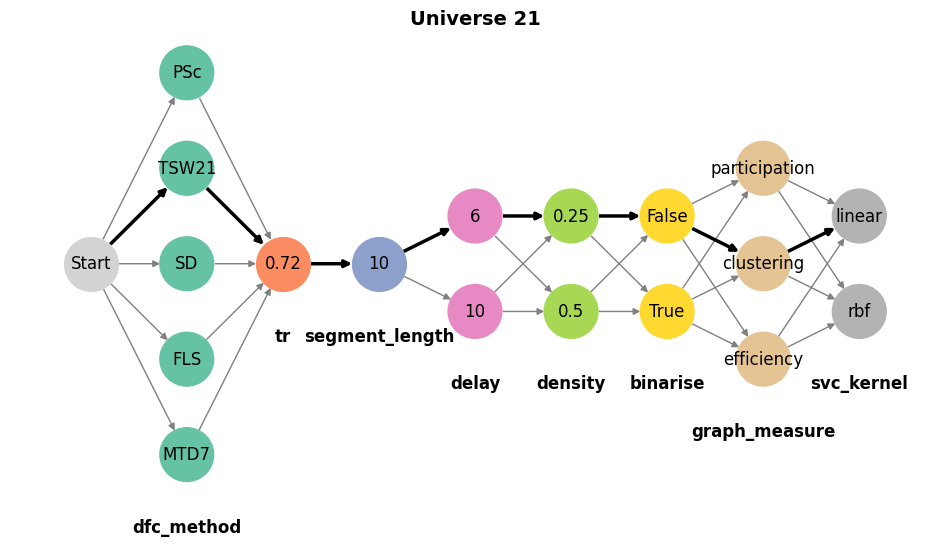

In [4]:
mverse.summary()
mverse.visualize(universe=21, figsize=(12, 6))

Plot the specififcation curve:

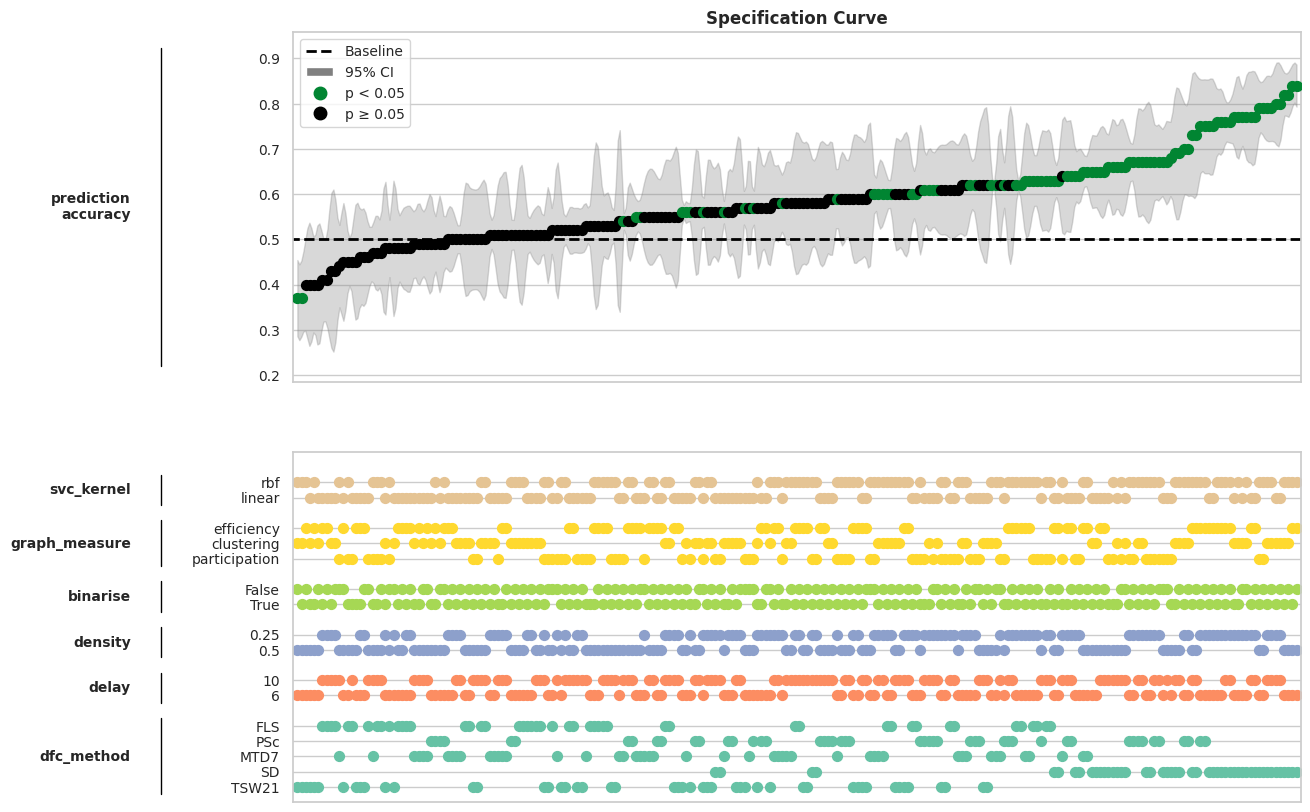

In [5]:
mverse.specification_curve(measure="prediction\naccuracy", title="Specification Curve", \
                           baseline=0.5, p_value=0.05, ci=95, smooth_ci=True, \
                           cmap="Set2", figsize=(13,10), fontsize=10, height_ratio=[1,1])

As we know the ground truth connectivity patterns from our simulated data, we can check if a pattern (e.g. universes with SD performing consistently better than almost all other universes) can be explained by the method giving more accurate results. For this, we load the connectivity estimates and calculate the average frobenius distance between the ground truth and the dFC as well as the graph estimates for each method:

In [ ]:
import numpy as np
import pandas as pd
from comet import utils

data_sim = utils.load_example("simulation.mat")

# Ground truth connectivity estimates
R = data_sim["R"]  # idx 0: state 6, idx 1: state 7
labels = data_sim["labels"].astype(int) # Labels: 6 and 7

# Load multiverse results
mverse_results = mverse.get_results()

# Calculate frobenius distances between true and estimated dFC estimates
universe_distance = {}

for universe in mverse_results:
    dfc = mverse_results[universe].get("dfc_estimates") # Shape: (100, 10, 10)

    distances = []
    for trial in range(dfc.shape[0]):
        # Get true and estimated dFC matrices
        R_true = R[:, :, 0] if labels[trial] == 6 else R[:, :, 1]
        R_est = dfc[trial, :, :]
        # Calculate distance
        distances.append(np.linalg.norm(R_true - R_est, ord='fro'))

    universe_distance[universe] = np.mean(distances)
# Get mean distance per method
rows = []
for u, dist in universe_distance.items():
    method = mverse_results[u]["decisions"]["Value 1"]
    rows.append({"universe": u, "method": method, "mean_distance": dist})

df = pd.DataFrame(rows)
summary = (df.groupby("method")["mean_distance"].agg(mean="mean", std=lambda x: x.std(ddof=1), n="count").sort_values("mean"))
print(summary)

            mean       std   n
method                        
SD      4.753474  0.008986  48
FLS     4.986114  0.024847  48
TSW21   5.334146  0.015510  48
PSc     5.676485  0.020543  48
MTD7    6.099478  0.033108  48


The results indicate that dFC estimates obtained using the Spatial Distance method align most closely with the ground truth, which may help explain its strong performance observed in the specification curve. Although such a comparison is not feasible with real data due to the absence of a ground truth, it serves as an illustrative example of how post-multiverse analyses can be used to gain further insights into observed patterns.